In [51]:
import matplotlib.pyplot as plt
from pandas import read_csv
from pathlib import Path
import os
import numpy as np
import xarray as xr
from dataclasses import dataclass
from typing import Literal

from collections import namedtuple

In [55]:
@dataclass(slots=True, frozen=True)
class Point:
    x:float
    y:float
    z:float

@dataclass
class boundaryProbe:
    path_data: str|Path 
    path_time: str|Path
    path_xyz: str|Path

    def __post_init__(self):
        for path in [self.path_data, self.path_time, self.path_xyz]:
            if isinstance(path, str):
                path = Path(path)

        ## Get the number of probed fields
        self.fields_names = self.path_data.stem.replace("points_", "").split("_")
        self.n_fields = len(self.fields_names)

        ## Get the number of probes
        self.get_probe_points()
        self.n_probes = len(self.probes_points)
        
        ## Get the timesteps
        self.get_times()

        ## Determine if vector or scalar data
        self.set_dimensionality()

        ## Initialize data arrays
        self.parse_data()

    def infer_number_data_columns(self):
        """Should be n_probes * n_fields * (1 or 3)"""
        with open(self.path_data) as f:
            first_line = f.readline().split()
            self.n_cols = len(first_line)
        
    def set_dimensionality(self):
        self.infer_number_data_columns()

        if self.n_cols == self.n_probes * self.n_fields:
            self.dimensionality = "scalar"
        elif self.n_cols == 3 * self.n_probes * self.n_fields:
            self.dimensionality = "vector"
        else:
            print("This is not working")
    
    def get_probe_points(self):
        xyz = np.loadtxt(self.path_xyz)
        self.probes_points = [Point(*coord) for coord in xyz]

    def get_times(self):
        self.list_of_times = np.loadtxt(self.path_time)

    def parse_data(self):
        full_data = np.loadtxt(self.path_data)

        data = dict()

        for i, field in enumerate(self.fields_names):
            data[field] = xr.DataArray(
                full_data[i::i+self.n_fields], dims=("time", "probe"), coords={"probe": self.probes_points, "time": self.list_of_times}
            )
        return data

In [54]:
casepath = Path(f"CASES/dry_60__flood_60/organizedData/")
files = casepath.glob("points_*")
f_time = casepath/"time.txt"
f_xyz = casepath/"xyz.txt"

for f in files:
    bp = boundaryProbe(f, f_time, f_xyz)
    print(bp.fields_names)
    print(bp.dimensionality)

FileNotFoundError: xyz.txt not found.

In [30]:
bp.parse_data().shape

(4, 3300)

In [36]:
bp.parse_data()[0::2].shape

(2, 3300)

In [94]:
Sw.to_numpy().shape

(3300, 2)

In [96]:
data

<xarray.DataArray (time: 3300, probe: 2)>
array([[1.      , 0.999996],
       [1.      , 0.99998 ],
       [1.      , 0.999958],
       ...,
       [0.959778, 0.500049],
       [0.959615, 0.499803],
       [0.959453, 0.499558]])
Coordinates:
  * probe    (probe) object Point(x=0.1, y=0.1, z=0.0) Point(x=0.1, y=0.1, z=...
  * time     (time) float64 0.001 0.002 0.003 ... 3.238e+04 3.239e+04 3.24e+04

/tmp/ipykernel_637676/3946369344.py:3: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for i, vel in velocity[[2,5]].iteritems():


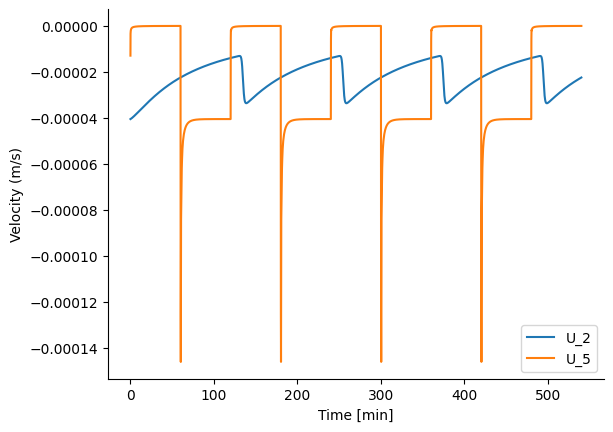

In [20]:
fig,ax = plt.subplots()

for i, vel in velocity[[2,5]].iteritems():
    ax.plot(time/60, vel, label=f"U_{i}")  ## Bottom

ax.legend()
ax.set_xlabel("Time [min]")
ax.set_ylabel("Velocity (m/s)")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

In [22]:
scalars

,0,1,2,3,4,5
0,-1.000930e-10,1.000000,0.000041,-0.000489,0.999996,4.041230e-05
1,-9.189790e-05,1.000000,0.000041,-0.000969,0.999980,4.024760e-05
2,-1.817280e-04,1.000000,0.000040,-0.001338,0.999958,4.010330e-05
3,-1.817280e-04,1.000000,0.000040,-0.001544,0.999941,4.001750e-05
4,-1.817280e-04,1.000000,0.000040,-0.001716,0.999925,3.994330e-05
...,...,...,...,...,...,...
3295,-2.779930e-02,0.960103,0.000023,-0.142994,0.500542,4.165260e-07
3296,-2.785240e-02,0.959941,0.000023,-0.143092,0.500295,4.153140e-07
3297,-2.790530e-02,0.959778,0.000023,-0.143189,0.500049,4.141080e-07
3298,-2.795820e-02,0.959615,0.000023,-0.143285,0.499803,4.129100e-07


/tmp/ipykernel_637676/2870614172.py:3: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for i, vel in scalars[[0,3]].iteritems():


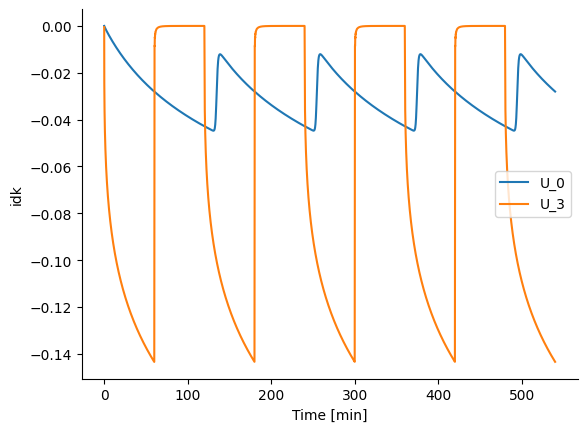

In [24]:
fig,ax = plt.subplots()

for i, vel in scalars[[0,3]].iteritems():
    ax.plot(time/60, vel, label=f"U_{i}")  ## Bottom

ax.legend()
ax.set_xlabel("Time [min]")
ax.set_ylabel("idk")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()